In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

seed = 32
ANOMALY = False # False means that we will not do the anomalies detection
LOAD_ORIGINAL_DATA = True # False means that we will use noised data
CLIMATIC_PATH ='KELIBIA.xlsx'
APP_PATH = 'apport.xlsx'
CLEANED_DATA = "cleaned_data.xlsx"

# I.Load data

## Load Climatic Data

In [13]:
def read_and_reformate_climatic_data(path):
    df = pd.read_excel(path, sheet_name='KELIBIA')
    df = df.drop(['NUM_STA','NOM_STA','Unnamed: 7'],axis=1)
    df.rename(columns={'DAT': 'DATE', 'Temp. Minimale °C' : 'Temp_min', 'Temp. Maximale °C':'Temp_max',
                        'Précipitation toat (mm)':'PLV', 'Evaporation Pch (mm)':'EVA'},inplace=True)
    df['DATE'] = pd.DatetimeIndex(df['DATE'])   
    df.set_index('DATE', inplace=True)
    return df

In [310]:
climatic_data = read_and_reformate_climatic_data(CLIMATIC_PATH)

## Load inflow target

In [14]:

def read_and_reformate_inflow(file):
    #convert string french months to numeric values
    df = pd.read_excel(file, sheet_name='Sheet1')
    df.rename(columns={'apport':'APP'},inplace=True)
    dates = df.pop('date')
    dates = dates.str.split(' ')
    months_names = ['Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Aôut','Septembre','Octobre','Novembre','Décembre']
    months_values = ['01/01','02/01','03/01','04/01','05/01','06/01','07/01','08/01','09/01','10/01','11/01','12/01']
    data_date_format = []
    for date in dates:
        index = months_names.index(date[0])
        data_date_format.append(months_values[index]+'/'+date[1])
    df['date']= pd.DatetimeIndex(data_date_format)  
    df.set_index('date', inplace=True)
    return df

In [5]:
inflow = read_and_reformate_inflow(APP_PATH)

In [15]:
# Read adn preprocess original data
def read_and_preprocess_data(data):
    data.drop_duplicates(keep='first', inplace=True)
    data.interpolate(inplace=True)
    data = data.fillna(method='ffill')
    data.dropna(axis=0, inplace=True)
    return data

In [8]:
climatic_data = read_and_preprocess_data(climatic_data)
inflow = read_and_preprocess_data(inflow)

In [26]:
len(climatic_data), len(inflow)

(237, 281)

# II.Anomalies injection

In [315]:
import sys
sys.path.append('./agots-master')
from agots.multivariate_generators.multivariate_data_generator import MultivariateDataGenerator
df = climatic_data.copy()
dg = MultivariateDataGenerator(df)

In [316]:
def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

In [317]:
## Create ramdom extreme noise
## This method return indexs in which we will inject extreme noise in the data
import random
def random_extreme_noise(df, percent=10):
    x = list(range(0, len(df)))
    #3% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for ano in index_of_anomalies:
        result.append((df.index[ano],))
    return result

In [318]:
## Create ramdom varience or shift noise
## This method return indexs in which we will inject extreme noise in the data
def random_variance_or_shift_noise(df, percent=3):
    x = list(range(0, len(df)))
    #3% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for x, y in grouped(index_of_anomalies, 2):
        result.append((df.index[x],df.index[y]))
    return result

In [319]:
## Create ramdom trend noise
## This method return indexs in which we will inject extreme noise in the data
def random_trend_noise(df, percent=0.08):
    x = list(range(0, len(df)))
    #0.1% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for x, y in grouped(index_of_anomalies, 2):
        result.append((df.index[x],df.index[y]))
    return result

In [320]:
## This method is used to add different types of noise to the Data
def add_noise_to_df(df, display_charts):
    all_noise_indexs_for_all_cols = []
    
    for col in df.columns:
        noise_indexs_for_curr_col = []
        extreme_noise=random_extreme_noise(df)
        variance_or_shift_noise = random_variance_or_shift_noise(df, percent=15)
        trend_noise = random_trend_noise(df)
        noise_indexs_for_curr_col.append(extreme_noise)
        
        noise_indexs_for_curr_col.append(variance_or_shift_noise)
        ##noise_indexs_for_curr_col.append(trend_noise)
        noise_indexs_for_curr_col.append(variance_or_shift_noise)
      
    
        dd = dg.add_outliers({'extreme': [{'n': df.columns.get_loc(col), 'timestamps': extreme_noise,
                                   'value': 0.5
                                  }],#'trend':   [{'n': df.columns.get_loc(col), 'timestamps': trend_noise, 'value': 0.10}]
                      'shift':   [{'n': df.columns.get_loc(col), 'timestamps': variance_or_shift_noise,
                                   'value': -0.4  # or 'value' (for a plain addition)
                                  }],
                      'variance':[{'n': df.columns.get_loc(col), 'timestamps': variance_or_shift_noise,
                                   'value': 0.2
                                  }]
                     })
        
        if display_charts == True:
            fig = plt.figure(figsize=(20,10))
            plt.title(col,fontsize=26, fontweight='bold')
            box = dict(facecolor='yellow', pad=5, alpha=0.2)  

            ax = fig.add_subplot(1, 2, 1)
            ax.plot(data.index, data[col], color='blue', label='Origonal data')
            plt.xlabel('Time')
            plt.ylabel(col, bbox=box)
            plt.legend() 

            ax = fig.add_subplot(1, 2, 2)
            ax.plot(dd.index,dd[col], color='red', label='Noised data')
            plt.xlabel('Time')
            plt.ylabel(col, bbox=box)
            plt.legend() 
            plt.show()
        
        all_noise_indexs_for_all_cols.append(noise_indexs_for_curr_col)
    return dd, all_noise_indexs_for_all_cols

In [321]:
display_charts = False
noised_df, noise_indexs = add_noise_to_df(df, display_charts)
noised_df['APP'] = inflow

In [322]:
pickle.dump(noised_df, open('noised_df.pkl', 'wb'))
pickle.dump(noise_indexs, open('noise_indexs.pkl', 'wb'))

In [323]:
def plot_anomalies_injections(df, noised_df):
    a = noised_df
    fig = plt.figure(figsize=(20,10))
    plt.title('Data without anomalies Vs Data with anomalies',fontsize=26, fontweight='bold')
    box = dict(facecolor='yellow', pad=5, alpha=0.2)  
    
    #Temp_min
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(a.index,a['Temp_min'], color='red', label='Anomaly')
    ax.plot(df.index, df['Temp_min'], color='blue', label='Normal')
    plt.xlabel('Time')
    plt.ylabel('Temp_min', bbox=box)
    plt.legend()    
        
    #Temp_max
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(a.index,a['Temp_max'], color='red', label='Anomaly')
    ax.plot(df.index, df['Temp_max'], color='blue', label='Normal')
    plt.xlabel('Time')
    plt.ylabel('Temp_max', bbox=box)
    plt.legend()
    
    #PLV
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(a.index,a['PLV'], color='red', label='Anomaly')
    ax.plot(df.index, df['PLV'], color='blue', label='Normal')
    plt.xlabel('Time')
    plt.ylabel('PLV', bbox=box)
    plt.legend()
    
    #EVA
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(a.index,a['EVA'], color='red', label='Anomaly')
    ax.plot(df.index, df['EVA'], color='blue', label='Normal')
    plt.xlabel('Time')
    plt.ylabel('EVA', bbox=box)
    plt.legend()
    plt.show()

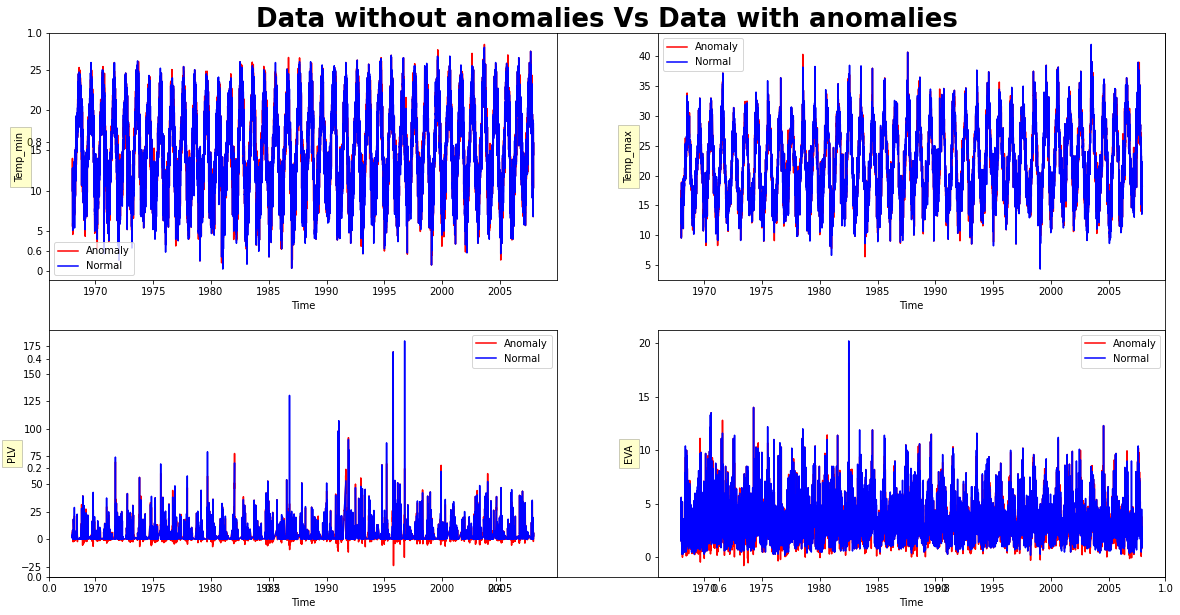

In [324]:
plot_anomalies_injections(climatic_data, noised_df)

# III.Load + Visualize + preprocessing Data

In [18]:
# Here we can load two types of Data, the original data of the noised data
def read_original_data(CLIMATIC_PATH, APP_PATH, LOAD_ORIGINAL_DATA):
    ## hre we load the original data that does not contain injected anomalies
    if LOAD_ORIGINAL_DATA== True:
        climatic_data = read_and_reformate_climatic_data(CLIMATIC_PATH)     
        inflow = read_and_reformate_inflow(APP_PATH)  
        return climatic_data, inflow
    ## here we load data in which we have injeced anomalies
    else:
        climatic_data = pickle.load(open('noised_df.pkl', 'rb'))
        inflow = climatic_data[['APP']]
        climatic_data  = climatic_data.drop(['APP'],axis=1)
        noise_indexs = pickle.load(open('noise_indexs.pkl', 'rb'))
        return climatic_data, inflow, noise_indexs

In [ ]:
if LOAD_ORIGINAL_DATA == True:
    climatic_data, inflow = read_original_data(CLEANED_DATA, APP_PATH, LOAD_ORIGINAL_DATA)
else:
    climatic_data, inflow, noise_indexs = read_original_data(CLIMATIC_PATH, APP_PATH, LOAD_ORIGINAL_DATA)

## Visualize Time Series

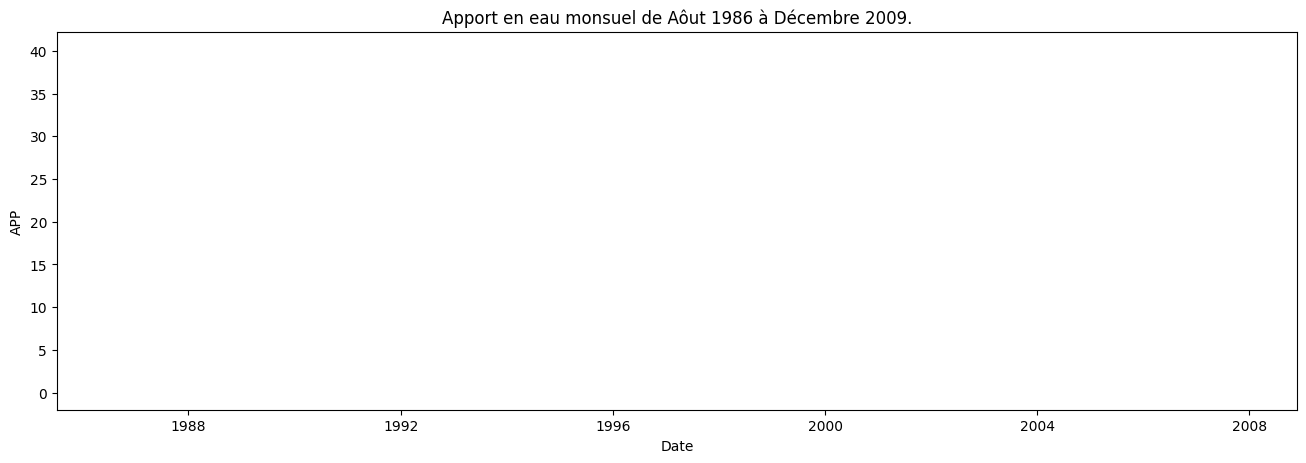

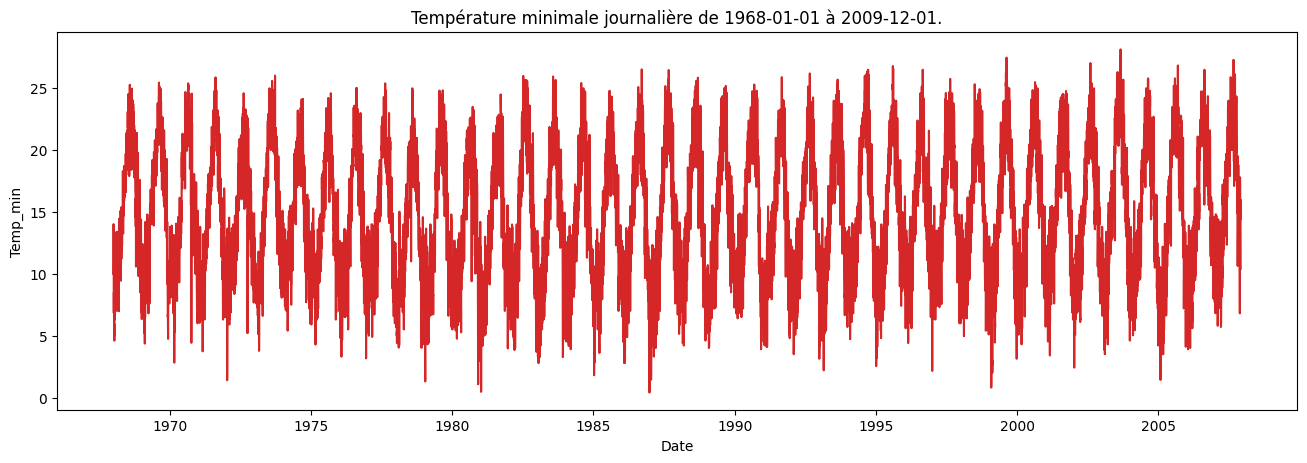

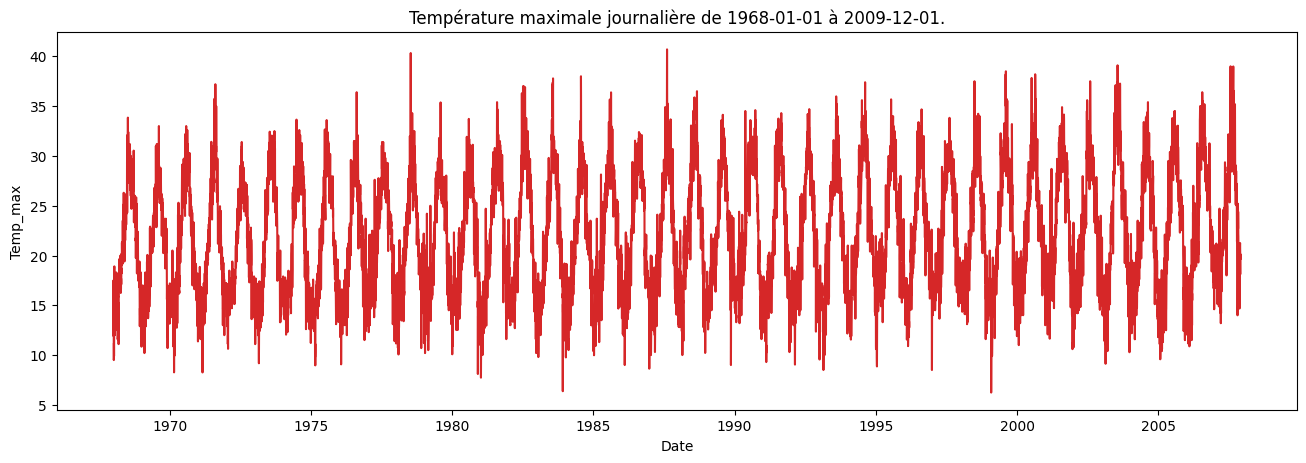

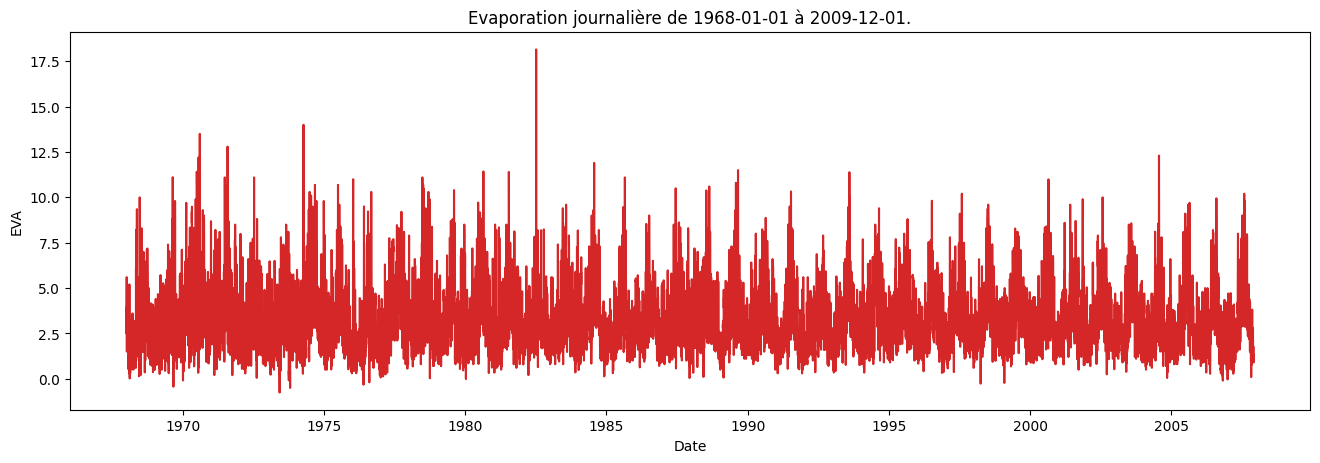

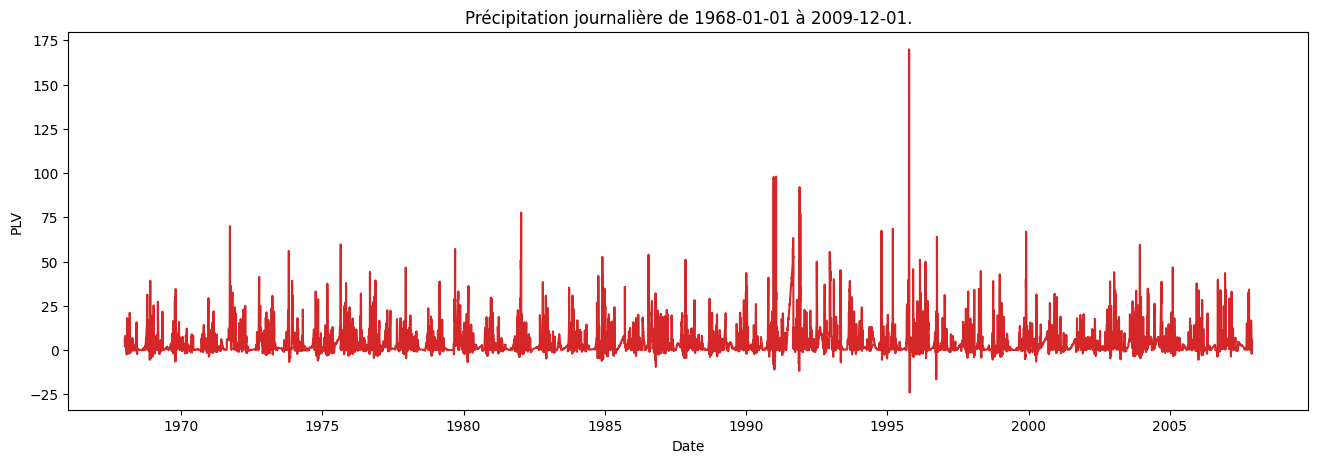

In [327]:
def plot_ts(df, x, y, title="", xlabel='Date', ylabel="", dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
# Inflow
plot_ts(inflow, x=inflow.index, y=inflow.APP, ylabel='APP', title='Apport en eau monsuel de Aôut 1986 à Décembre 2009.') 
# Temp_min
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_min, ylabel='Temp_min', title='Température minimale journalière de 1968-01-01 à 2009-12-01.') 
# Temp_max
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_max, ylabel='Temp_max', title='Température maximale journalière de 1968-01-01 à 2009-12-01.') 
# EVA
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.EVA, ylabel='EVA', title='Evaporation journalière de 1968-01-01 à 2009-12-01.') 
# PLV
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.PLV, ylabel='PLV', title='Précipitation journalière de 1968-01-01 à 2009-12-01.') 

## Data Preprocessing

In [21]:
def preprocessing(original_data):
    clean_data = original_data.copy()
    clean_data.drop_duplicates(keep='first', inplace=True)
    ### fill missing data 
    clean_data.interpolate(inplace=True)
    clean_data.fillna(method='bfill',inplace=True)    
    print('missing values:',clean_data.isna().sum().sum())
    return clean_data

climatic_data_cleaned = preprocessing(climatic_data)
climatic_data_cleaned.describe()

missing values: 0


,EVA_25%,EVA_50%,EVA_75%,EVA_max,EVA_mean,EVA_min,EVA_std,PLV_25%,PLV_50%,PLV_75%,...,Temp_max_mean,Temp_max_min,Temp_max_std,Temp_min_25%,Temp_min_50%,Temp_min_75%,Temp_min_max,Temp_min_mean,Temp_min_min,Temp_min_std
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,0.067649,0.079662,0.145639,0.084239,0.101275,0.086161,0.085414,-0.015000,0.023717,0.114566,...,0.155931,0.117209,0.094166,0.045047,0.091877,0.082615,0.066697,0.096395,0.023361,0.109803
std,0.163166,0.174691,0.194861,0.240109,0.180848,0.147051,0.165319,0.071674,0.155667,0.172030,...,0.243562,0.139409,0.218515,0.162143,0.154200,0.192299,0.176841,0.160434,0.182736,0.235319
min,-0.246572,-0.282434,-0.305896,-0.400113,-0.312974,-0.205234,-0.277704,-0.086412,-0.151981,-0.094268,...,-0.225221,-0.265780,-0.394043,-0.263134,-0.257228,-0.338530,-0.510790,-0.248774,-0.363615,-0.473132
25%,-0.046179,-0.037497,0.015227,-0.073272,-0.022588,-0.023265,-0.018410,-0.059224,-0.090265,-0.004579,...,-0.059045,0.012855,-0.054343,-0.078246,-0.018687,-0.060451,-0.065345,-0.017091,-0.123306,-0.042948
50%,0.053299,0.059865,0.131191,0.041434,0.080147,0.069669,0.051479,-0.039455,-0.017248,0.077067,...,0.080582,0.085137,0.108745,0.004443,0.069476,0.049944,0.051432,0.051377,-0.017706,0.097552
75%,0.166499,0.177236,0.251522,0.198134,0.202531,0.163672,0.171648,0.000308,0.077494,0.179556,...,0.360159,0.204273,0.239653,0.152807,0.202932,0.214899,0.212086,0.207224,0.152142,0.273154
max,0.568090,0.713552,0.851810,0.935543,0.647700,0.547577,0.752047,0.434695,0.682474,0.912959,...,0.688685,0.479938,0.632968,0.479800,0.490176,0.516304,0.408346,0.511335,0.495458,0.744375


## Split Into 4 Seasonal Datasets

In [329]:
saisons = ['Automne', 'Hiver', 'Printemps', 'Eté']

def create_seasonal_data(full_data):
    data = [pd.DataFrame() for i in range(4)]     
    month = pd.DatetimeIndex(full_data.index).month
    #Autumn
    data[0] = full_data[np.logical_or(month==9,np.logical_or(month==10,month==11))] 
    #Winter
    data[1] = full_data[np.logical_or(month==12,np.logical_or(month==1, month==2))]   
    #Spring
    data[2] = full_data[np.logical_or(month==3,np.logical_or(month==4, month==5))]
    #Summer
    data[3] = full_data[np.logical_or(month==6,np.logical_or(month==7, month==8))] 
    return data

seasonal_data = create_seasonal_data(climatic_data_cleaned)

# IIII.Anomaly Detection

### 1- split train & test data

In [330]:
from sklearn.model_selection import train_test_split
def split_data_into_train_and_test_sets(seasonal_data):
    train_seasonal_data = []
    for index , subset_elem in enumerate(seasonal_data):
        data_train, data_test = train_test_split(subset_elem, test_size=0.15, random_state=seed, shuffle=True)
        train_seasonal_data.append(data_train)
    return train_seasonal_data

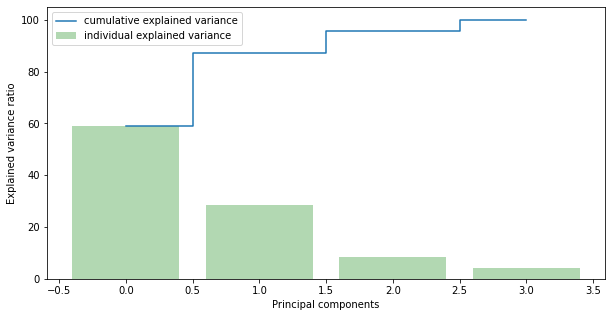

In [331]:
### Principal Components Analysis
# find the number of components (features) to keep                          
mean_vec = np.mean(data_train, axis=0)
cov_mat = np.cov(data_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

### 6. Anomaly Detection & Filtering

In [332]:
def build_detecor(data, detector):
    #scaling
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    # PCA dimensionality reduction
    pca = PCA(n_components=3).fit(data) # !!! scaled training data
    data = pd.DataFrame(pca.transform(data), index=data.index, columns = ['PC1', 'PC2', 'PC3'])
    # anomaly detector
    detector = detector.fit(data)
    return scaler, pca, detector

def anomaly_detection(data, scaler, pca, detector, is_fit):
    transformed_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    transformed_data = pd.DataFrame(pca.transform(transformed_data), index=transformed_data.index, columns = ['PC1', 'PC2', 'PC3'])
    #pred  = detector.predict(transformed_data)
    if is_fit== True:
        detector  = detector.fit(transformed_data)
        if detector.__class__.__name__ =='LocalOutlierFactor':
            pred  = detector.fit_predict(transformed_data)
        else:
            pred  = detector.predict(transformed_data)
    else:
        pred  = detector.fit_predict(transformed_data)
    
    data['anomaly'] = pred
    outliers = list(data[data['anomaly']==-1].index)    
    return transformed_data, data, outliers

def filter_outlier(X, outliers):
    X.loc[outliers, :] = np.nan
    X.interpolate(inplace=True)
    X.fillna(method='bfill',inplace=True)    
    return X


def plot_and_test_errors_of_sesonal_anomalies(train_seasonal_data, seasonal_data, model, is_fit = True):
    fig = plt.figure(figsize=(20,10))
    outliers = [None] * 4

    for index , subset_elem in enumerate(train_seasonal_data):

        ax = fig.add_subplot(2, 2, index+1, projection='3d')

        # build anomay detector
        scaler, pca, detector = build_detecor(subset_elem, model)

        # anomaly detection
        transformed_data, seasonal_data[index], outliers[index] = anomaly_detection(seasonal_data[index], scaler, pca, detector, is_fit)

        #Plot the compressed data points
        ax.scatter(transformed_data.loc[:,'PC1'], transformed_data.loc[:,'PC2'], zs=transformed_data.loc[:,'PC3'], s=4, lw=1, label="inliers",c="green")
        ax.scatter(transformed_data.loc[outliers[index],'PC1'],transformed_data.loc[outliers[index],'PC2'],transformed_data.loc[outliers[index],'PC3'],lw=2, s=60, marker="x", c="red", label="outliers")
        ax.title.set_text(saisons[index])
        ax.legend()    

        # filter anomalies
        seasonal_data[index] = filter_outlier(seasonal_data[index], outliers[index])    

    plt.show()
    return seasonal_data, outliers

In [333]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.covariance import EllipticEnvelope

from mpl_toolkits.mplot3d import Axes3D

## Use fit_predict
DB = DBSCAN(eps =0.6, metric='euclidean', min_samples=3, n_jobs=-1)
LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.01)
## Use predict
IForest=IsolationForest(n_estimators=100,max_samples='auto',
                        contamination=0.01,max_features=1.0,
                        bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
EE = EllipticEnvelope()
percent_of_tolerated_errors = 0.5

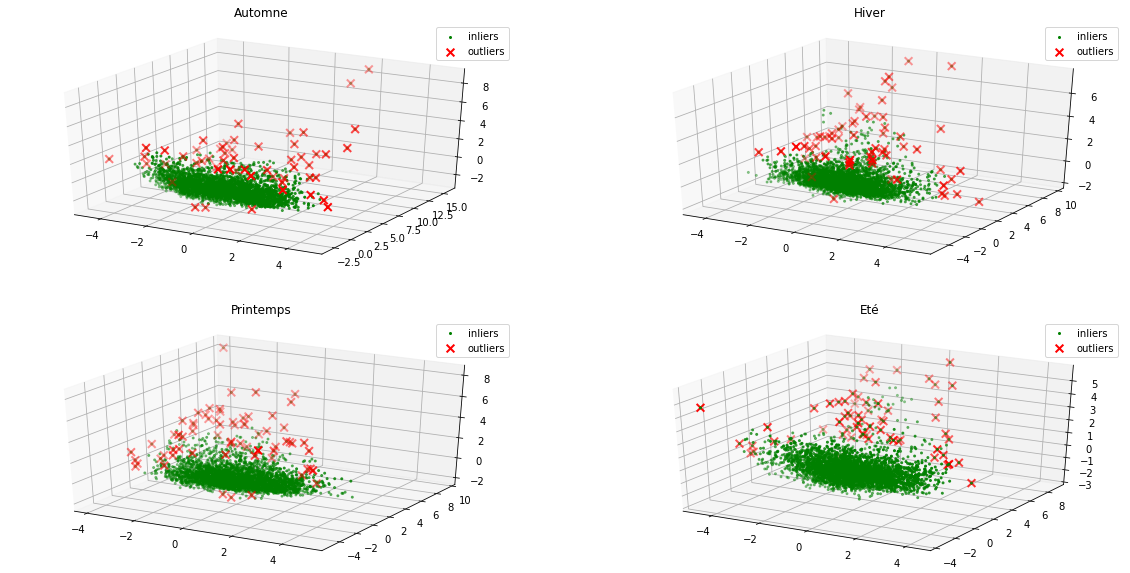

In [337]:
seasonal_data = create_seasonal_data(climatic_data_cleaned)
train_seasonal_data = split_data_into_train_and_test_sets(seasonal_data)
seasonal_data, outliers = plot_and_test_errors_of_sesonal_anomalies(train_seasonal_data, seasonal_data, DB, is_fit = False)

Detected anomalies for season: Automne


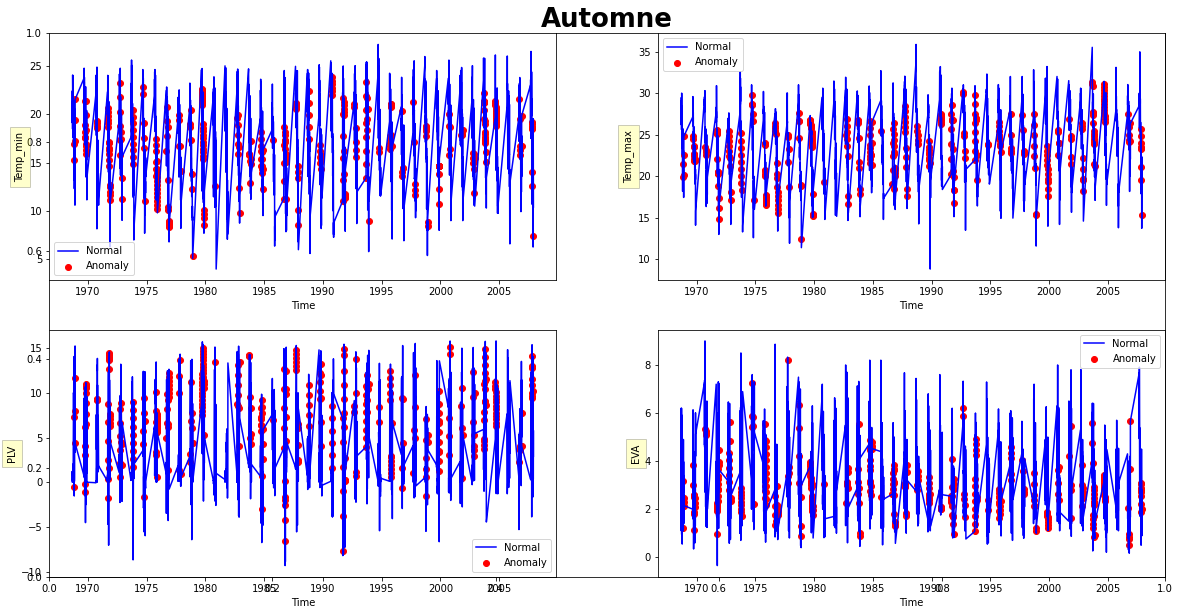

Detected anomalies for season: Hiver


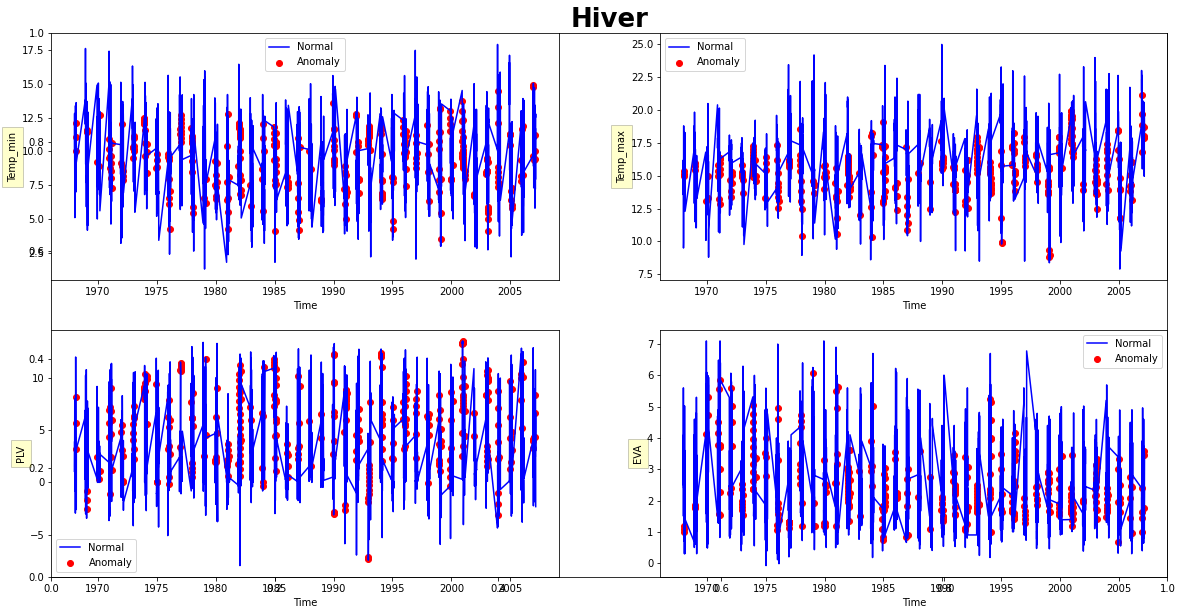

Detected anomalies for season: Printemps


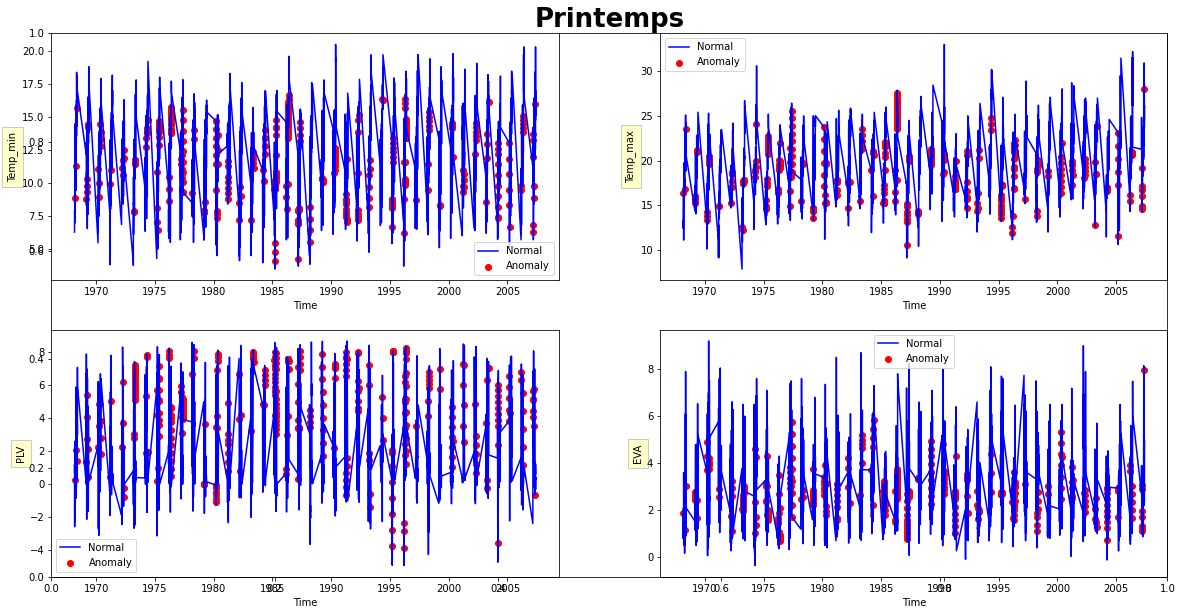

Detected anomalies for season: Eté


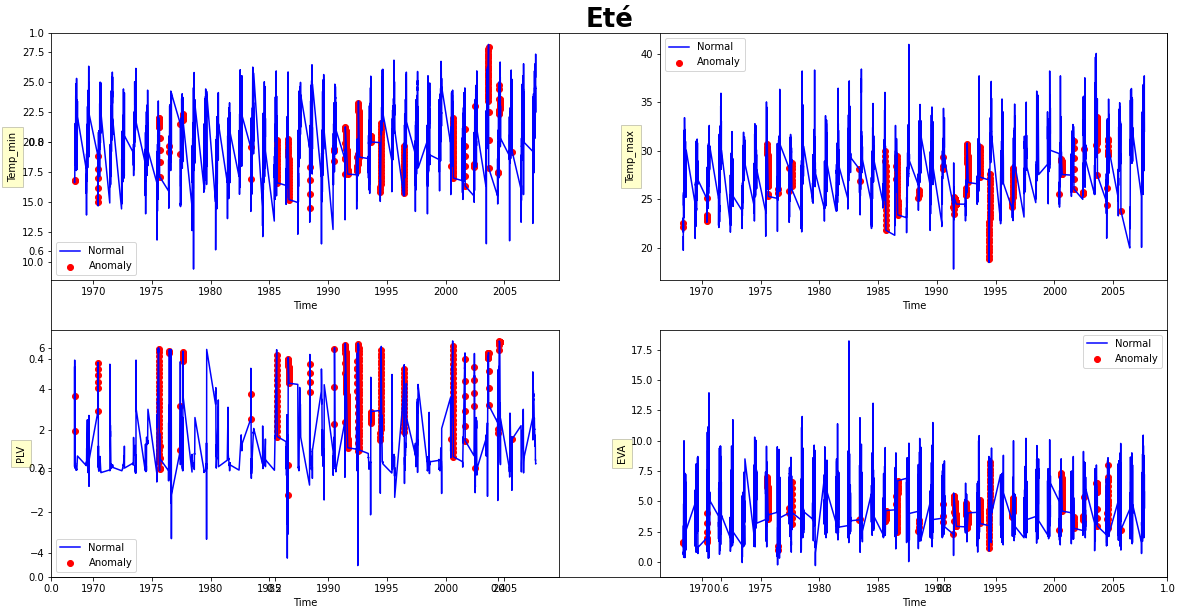

In [273]:
def plot_anomalies(df, outliers, saison):
        
    fig = plt.figure(figsize=(20,10))
    plt.title(saison,fontsize=26, fontweight='bold')
    box = dict(facecolor='yellow', pad=5, alpha=0.2)  
    
    #Temp_min
    ax = fig.add_subplot(2, 2, 1)
    a = df.loc[outliers, ['Temp_min']] #anomaly
    ax.plot(df.index, df['Temp_min'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_min'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_min', bbox=box)
    plt.legend()    
        
    #Temp_max
    ax = fig.add_subplot(2, 2, 2)
    a = df.loc[outliers, ['Temp_max']] #anomaly
    ax.plot(df.index, df['Temp_max'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_max'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_max', bbox=box)
    plt.legend()
    
    #PLV
    ax = fig.add_subplot(2, 2, 3)
    a = df.loc[outliers, ['PLV']] #anomaly
    ax.plot(df.index, df['PLV'], color='blue', label='Normal')
    ax.scatter(a.index,a['PLV'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('PLV', bbox=box)
    plt.legend()
    
    #EVA
    ax = fig.add_subplot(2, 2, 4)
    a = df.loc[outliers, ['EVA']] #anomaly
    ax.plot(df.index, df['EVA'], color='blue', label='Normal')
    ax.scatter(a.index,a['EVA'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('EVA', bbox=box)
    plt.legend()
    plt.show()
    
for i in range(4):
    print('Detected anomalies for season:', saisons[i])
    plot_anomalies(seasonal_data[i].sort_index(), outliers[i], saisons[i])


In [274]:
## concatunate cleaned seasonal data
if(ANOMALY):
    climatic_data_cleaned = pd.concat(seasonal_data)
    climatic_data_cleaned = climatic_data_cleaned.sort_index()

In [9]:
climatic_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EVA_25%        237 non-null    float64
 1   EVA_50%        237 non-null    float64
 2   EVA_75%        237 non-null    float64
 3   EVA_max        237 non-null    float64
 4   EVA_mean       237 non-null    float64
 5   EVA_min        237 non-null    float64
 6   EVA_std        237 non-null    float64
 7   PLV_25%        237 non-null    float64
 8   PLV_50%        237 non-null    float64
 9   PLV_75%        237 non-null    float64
 10  PLV_max        237 non-null    float64
 11  PLV_mean       237 non-null    float64
 12  PLV_min        237 non-null    float64
 13  PLV_std        237 non-null    float64
 14  Temp_max_25%   237 non-null    float64
 15  Temp_max_50%   237 non-null    float64
 16  Temp_max_75%   237 non-null    float64
 17  Temp_max_max   237 non-null    float64
 18  Temp_max_m

# Concatunate climatic data & inflow

In [22]:
from sklearn.model_selection import train_test_split
def concatunate_inflow(data_cleaned, inflow): 
    data = data_cleaned.copy()
    data['APP'] = np.nan
    for year in sorted(pd.unique(pd.DatetimeIndex(inflow.index).year)):
        for month in range(1,13):
            index_app = list(inflow[np.logical_and(year==pd.DatetimeIndex(inflow.index).year, 
                                                   month==pd.DatetimeIndex(inflow.index).month)].index)
            index_data = list(data[np.logical_and(year==pd.DatetimeIndex(data.index).year, 
                                               month==pd.DatetimeIndex(data.index).month)].index)
            if len(index_data)>0 and len(index_app)>0:
                data.loc[index_data, 'APP'] = inflow.loc[index_app, 'APP'].values[0]   
    data.dropna(axis=0,inplace=True)
    return data

data_inflow = concatunate_inflow(climatic_data_cleaned, inflow)
data_inflow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EVA_25%        0 non-null      float64
 1   EVA_50%        0 non-null      float64
 2   EVA_75%        0 non-null      float64
 3   EVA_max        0 non-null      float64
 4   EVA_mean       0 non-null      float64
 5   EVA_min        0 non-null      float64
 6   EVA_std        0 non-null      float64
 7   PLV_25%        0 non-null      float64
 8   PLV_50%        0 non-null      float64
 9   PLV_75%        0 non-null      float64
 10  PLV_max        0 non-null      float64
 11  PLV_mean       0 non-null      float64
 12  PLV_min        0 non-null      float64
 13  PLV_std        0 non-null      float64
 14  Temp_max_25%   0 non-null      float64
 15  Temp_max_50%   0 non-null      float64
 16  Temp_max_75%   0 non-null      float64
 17  Temp_max_max   0 non-null      float64
 18  Temp_max_mean  0 non-n

# Time Series Feature Engineering 

# concat seasonal_X[i]
all_seasonal_X = pd.concat(seasonal_X)
all_seasonal_data = pd.concat(seasonal_data)

print(all_seasonal_X.info())
print(all_seasonal_data.info())

#drop monthly series with nan inflow
X_clean = all_seasonal_X.loc[all_seasonal_data['APP'].notna()]
X_clean['APP'] = all_seasonal_data.loc[X_clean.index, 'APP']

# prepare test dataset
print('Missing values in test dataset:', data_test.isna().sum().sum())
X_comp_test['APP'] = data_test['APP']
X_comp_test.head()

clean_data_inflow = data_inflow.dropna(axis=0, inplace=False)
clean_data = clean_data_inflow.drop('APP', axis=1)
clean_data = pd.DataFrame(StandardScaler().fit_transform(clean_data), index=clean_data_inflow.index,
                          columns = clean_data.columns)
clean_data['APP'] = clean_data_inflow['APP'] 

In [277]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters, ComprehensiveFCParameters, MinimalFCParameters

extraction_settings = MinimalFCParameters()

def feature_extraction(df, method='describe'):   
    # Prepare time series : each monthly time serie has an ID and Time in range (0, length(serie))
    data = df.copy()
    data['ID'] = None
    data['Time'] = None
    ID = 1  
    ts_date = []
    for month in range(1,13): 
        for year in pd.unique(pd.DatetimeIndex(data.index).year):                   
            Serie_index = list(data[np.logical_and(year==pd.DatetimeIndex(df.index).year, 
                                        month==pd.DatetimeIndex(df.index).month)].index)
            if len(Serie_index)>0:
                time = list(range(0, len(Serie_index)))
                data.loc[Serie_index, 'ID'] = ID
                data.loc[Serie_index, 'Time'] = time
                ts_date.append(Serie_index[0])
                ID = ID+1  
                
    target = pd.Series(data.loc[data['Time']==0,'APP'].values, index=range(1,data['ID'].max()+1))
   
    if(method=='tsfresh'):
        features = extract_relevant_features(data.drop('APP', axis=1), target, column_id='ID', column_sort='Time',
                                             default_fc_parameters=extraction_settings)
    else:
        features = data.drop(['APP','Time'], axis=1).groupby(['ID']).describe() 
        #features.drop([('PC1', 'count'), ('PC2', 'count'), ('PC3', 'count')], axis=1, inplace= True)
        features.drop([('Temp_min', 'count'), ('Temp_max', 'count'), ('PLV', 'count'), ('EVA', 'count')], axis=1, inplace= True)
    
    features['DATE'] = ts_date
    features.set_index('DATE', inplace=True)        
    return features, target

ts_features, ts_targets = feature_extraction(data_inflow)

In [278]:
names = []
for i in range(len(ts_features.columns)):
    names.append('F'+str(i))

ts_features= pd.DataFrame(ts_features.values, columns=names, index=ts_features.index)
ts_features.sort_index(inplace=True)

In [279]:
ts_features_targets = ts_features.copy()
ts_features_targets['APP'] = ts_targets.values
ts_features_targets.sort_index(inplace=True)

# Split & Scaling & Transformation

In [32]:
#ts_features_targets = pd.read_excel(CLEANED_DATA)

In [30]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
X = ts_features_targets.drop('APP', axis=1)
y = ts_features_targets[['APP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)

In [31]:
# scaling and transform data
from sklearn.preprocessing import PowerTransformer, StandardScaler
def data_scaling_transform(X_train, X_test, y_train, y_test):
    ### transform input variables
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    ### transform target variables
    transformer = PowerTransformer().fit(y_train)
    y_train = transformer.transform(y_train)
    y_test = transformer.transform(y_test)     
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_scaling_transform(X_train, X_test, y_train, y_test)

# Modeling 

In [33]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(HuberRegressor())
    models.append(Ridge())
    models.append(Lasso(max_iter=1500))
    models.append(KNeighborsRegressor(n_neighbors=3))
    models.append(SVR())
    models.append(DecisionTreeRegressor())
    models.append(ExtraTreeRegressor())
    models.append(BaggingRegressor(base_estimator=DecisionTreeRegressor()))
    models.append(RandomForestRegressor())
    models.append(ExtraTreesRegressor())
    models.append(AdaBoostRegressor(random_state=seed))
    models.append(GradientBoostingRegressor(random_state=seed))
    models.append(XGBRegressor(objective ='reg:squarederror'))
    models.append(MLPRegressor())
    return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
    # define split of data
    splits = 5
    kfold = KFold(n_splits=5, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X):
        splits-=1
        fold_yhats = list()
        # get data
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        meta_y.extend(test_y)
        # fit and make predictions with each sub-model
        for model in models:
            #print((train_X.dtypes), (train_y.dtypes))            
            model.fit(train_X, train_y)
            yhat = model.predict(test_X)
            # store columns
            fold_yhats.append(yhat.reshape(len(yhat),1))
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for index, model in enumerate(models):
        models[index] = model.fit(X, y)
    return models   

# fit a meta model
def fit_meta_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    df  = pd.DataFrame()
    for model in models:
        yhat = model.predict(X)
        mse = mean_squared_error(y, yhat)
        #print('%s: RMSE: %.3f , R2: %3f '  % (model.__class__.__name__, sqrt(mse), r2_score(y, yhat)))
        df = df.append(pd.DataFrame([[model.__class__.__name__, sqrt(mse), r2_score(y, yhat)]],columns=['model_name','RMSE','R2']))
    return df

def super_learner_predictions(X, models, meta_model):
    meta_X = list()    
    for model in models:
        yhat = model.predict(X)
        meta_X.append(yhat.reshape(len(yhat),1))
    meta_X = hstack(meta_X)
    # predict
    return meta_model.predict(meta_X)
    
def train(X, X_val, y, y_val):
   
    # get models
    models = get_models()
    # get out of fold predictions
    start_time = time.time() 
    meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
    #print('Meta ', len(meta_X), len(meta_y))
    # fit base models
    models = fit_base_models(X, y, models)
    # fit the meta model
    meta_model = fit_meta_model(meta_X, meta_y)
    print("--- %s seconds ---" % (time.time() - start_time))
    # evaluate base models
    res = evaluate_models(X_val, y_val, models)
    # evaluate meta model
    yhat = super_learner_predictions(X_val, models, meta_model)

    #res  = pd.DataFrame()
    res = res.append(pd.DataFrame([[meta_model.__class__.__name__, sqrt(mean_squared_error(y_val, yhat)), r2_score(y_val, yhat)]],columns=['model_name','RMSE','R2']))
    #print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))
    #print('Super Learner: R2 %.3f' % (r2_score(y_val, yhat)))
    return res

In [35]:
result = train(X_train.reset_index(), X_test.reset_index(), pd.DataFrame(y_train,columns=['app']).app, pd.DataFrame(y_test,columns=['app']).app)

--- 4.303157806396484 seconds ---


In [284]:
result.to_excel('results.xlsx', index= False)

def train_test_models(X_train, y_train, X_test, y_test):
    result = pd.DataFrame()
    shuffle = KFold(n_splits=10, shuffle=True, random_state=seed)
    models = get_models()
    for index, model in enumerate(models):
        scores = cross_validate(model, X_train, y_train, cv=shuffle, scoring='r2',return_estimator=True)
        # index of best score
        pos_max = np.argmax(scores['test_score'])
        y_pred = scores['estimator'][pos_max].predict(X_test)
        r2 = r2_score(y_test, y_pred)
        models[index] = scores['estimator'][pos_max] 
        result = result.append(pd.DataFrame([[model.__class__.__name__, r2]], columns=['Models','R2']))
    return models, result 

models, result  = train_test_models(X_train, y_train, X_test, y_test)
print(result)